<a href="https://colab.research.google.com/github/Layana7592/Python/blob/main/Bird_identification_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Kaggle dataset download setup
!mkdir -p ~/.kaggle
!echo '{"username":"your_username","key":"your_api_key"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d umairshahpirzada/birds-20-species-image-classification
!unzip -q birds-20-species-image-classification.zip -d /content/dataset

Dataset URL: https://www.kaggle.com/datasets/umairshahpirzada/birds-20-species-image-classification
License(s): unknown
 82% 57.0M/69.3M [00:00<00:00, 152MB/s]
100% 69.3M/69.3M [00:00<00:00, 157MB/s]


In [ ]:
# Define dataset paths
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/valid"
test_dir = "/content/dataset/test"

In [ ]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE=32

In [ ]:
# Data augmentation & preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


In [ ]:
# Load pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=out)

In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train model
EPOCHS = 10
history = model.fit(
    train_generator, epochs=EPOCHS, validation_data=val_generator,verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 72s 567ms/step - accuracy: 0.1009 - loss: 3.0205 - val_accuracy: 0.3900 - val_loss: 2.3577
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 451ms/step - accuracy: 0.2427 - loss: 2.5159 - val_accuracy: 0.5900 - val_loss: 1.8013
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 444ms/step - accuracy: 0.3687 - loss: 2.1788 - val_accuracy: 0.6900 - val_loss: 1.4263
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 446ms/step - accuracy: 0.4286 - loss: 1.9477 - val_accuracy: 0.7500 - val_loss: 1.2296
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 452ms/step - accuracy: 0.4575 - loss: 1.8081 - val_accuracy: 0.7600 - val_loss: 1.0921
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - accuracy: 0.4934 - loss: 1.6995 - val_accuracy: 0.7600 - val_loss: 0.9720
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - accuracy: 0.5152 - loss: 1.6295 - val_accuracy: 0.8000 - val_loss: 0.8665
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 449ms/step - accuracy: 0.5634 - loss: 1

In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {accuracy*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.7573 - loss: 0.7440
Test Accuracy: 75.00%


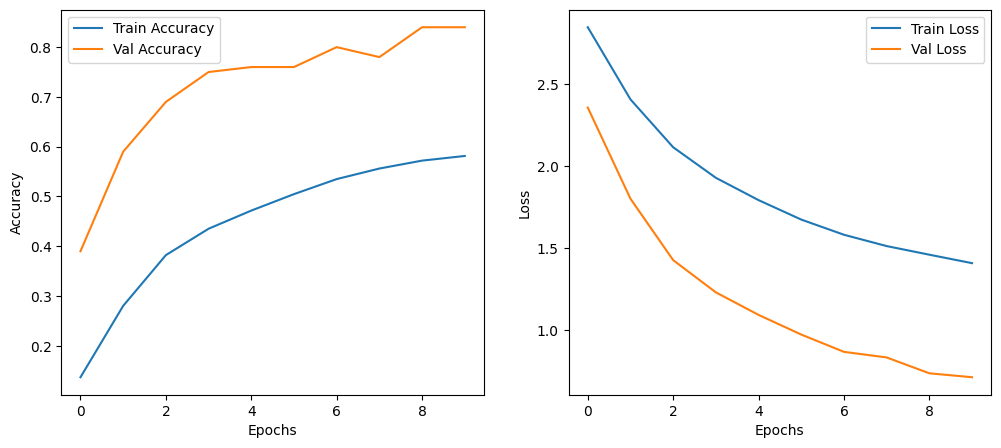

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [ ]:
# Save model
model.save("vgg19_bird_classifier.h5")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
#prediction

from skimage.io import imread
from skimage.transform import resize

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
def predict_new(imgpath,model1):
  img = imread(imgpath)
  cv2_imshow(img)
  img1 = resize(img,(224,224))
  # print(img1.shape)
  img1 = img1.reshape(1,224,224,3)
  # print(img1.shape)
  pred = model1.predict(img1)
  # print(pred)
  index=pred.argmax()
  # print(index)
  datadir=os.listdir('/content/dataset/test')
  # datadir=['without_mask','with_mask']
  datadir.sort()
  print(datadir[index])

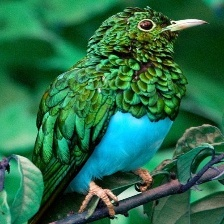

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
AFRICAN EMERALD CUCKOO


In [ ]:
# Example usage
predict_new("/content/dataset/test/AFRICAN EMERALD CUCKOO/2.jpg",model)